In [55]:
import os
import torch
from torchvision.datasets.utils import download_url
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
import models

In [3]:
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False

### Load data

In [4]:
# Read data - short version 3400+ documents
reuters = pd.read_pickle('input/reuters_small.pkl')
print(len(reuters))
reuters[0:2]

3426


,codes,headline,text,classes,classes_pad
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


In [6]:
# 8x small size
reuters = pd.read_pickle('input/reuters_small8.pkl')
print(len(reuters))
reuters[0:2]

24247


,codes,headline,text,classes
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]"
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]"


In [6]:
# load full data, if produced. 435 MB. NOT in Github currently. 
# You can produce this in about 30 min with preprocess_data.ipynb

reuters = pd.read_pickle('input/reuters_all.pkl')

In [7]:
# read classcodes
classcodes= pd.read_csv('input/classcodes.csv')
print(len(classcodes))
#classcodes[0:12]

# add index field to DataFrame
classcodes = classcodes.reset_index()
# Create dictionary index/int to classcode and classcode to int
itocode = dict(zip(classcodes.index, classcodes.Code))
codetoi = dict(zip(classcodes.Code, classcodes.index))
def listToInt(mylist):
    return [codetoi[item] for item in mylist]

reuters['codes'] = [listToInt(codelist) for codelist in reuters.codes]
reuters[0:3]
# Multihot, for single list - one row
def multihot(tags):
    return [1 if tag in tags else 0 for tag in taglist]

# list of classes, 126 int: [0...125]
taglist = list(classcodes.index)
Y_hot = [multihot(claslist) for claslist in reuters.codes]
reuters['codes'] = Y_hot

126


In [8]:
print(len(reuters))
reuters[0:3]

24247


,codes,headline,text,classes
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Official Journal contents - OJ L 190 of July 1...,\n*\n(Note - contents are displayed in reverse...,"[80, 90]"


### Using DataSet


Example in:
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb

In [9]:
#Define the Fields
TEXT = data.Field()
HEADLINE = data.Field()
LABELS = data.LabelField(sequential=False, use_vocab=False)

In [10]:
# Put data in random order
idx = np.random.permutation(len(reuters))
reuters = reuters.iloc[idx]

In [11]:
# split it
size = len(reuters)
train_size = int(0.7*size)
test_size = int(0.85*size)

train = reuters[0: train_size]
val = reuters[train_size : test_size]
test = reuters[test_size : size]

train.to_json('input/train.json', orient='records', lines=True)
test.to_json('input/test.json', orient='records', lines=True)
val.to_json('input/val.json', orient='records', lines=True)

In [12]:
# Tell torchText which Fields to apply to which json elements

fields = {'headline': ('h', HEADLINE), 'text': ('t', TEXT), 'codes': ('l', LABELS)}
fields

{'headline': ('h', <torchtext.data.field.Field at 0x7fd10dce9908>),
 'text': ('t', <torchtext.data.field.Field at 0x7fd10dce9710>),
 'codes': ('l', <torchtext.data.field.LabelField at 0x7fd10dce9748>)}

In [13]:
# Create dataset (TabularDataset)
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'input',
                                        train = 'train.json',
                                        validation = 'val.json',
                                        test = 'test.json',
                                        format = 'json',
                                        fields = fields
)
# test
#print(vars(train_data[2]))

### continue

In [14]:
# GLOVE

#TEXT.build_vocab(train)
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.50d")
HEADLINE.build_vocab(train)
LABELS.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 50])


In [15]:
TEXT.vocab

In [16]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print('------------')
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABELS vocabulary: {len(LABELS.vocab)}")

Number of training examples: 16972
Number of validation examples: 3637
Number of testing examples: 3638
------------
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABELS vocabulary: 4


In [17]:
print(TEXT.vocab.freqs.most_common(10))
print('-----')
print(TEXT.vocab.itos[:10])
print(LABELS.vocab.stoi)

[('the', 162964), ('of', 88791), ('to', 88425), ('in', 69980), ('a', 65481), ('and', 65376), ('on', 39560), ('said', 31579), ('for', 30508), ('The', 25556)]
-----
['<unk>', '<pad>', 'the', 'of', 'to', 'in', 'a', 'and', 'on', 'said']
defaultdict(<function _default_unk_index at 0x7fd184ae6d08>, {'classes': 0, 'codes': 1, 'headline': 2, 'text': 3})


In [18]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t)
)

### F1 accuracy

The results will be ranked according to the highest micro-averaged F1 score. 
This will be calculated using the f1_score function found in scikit-learn, using a command like 
f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred 
the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document
i contains the label j.

Scikit:  Micro-average in F1-score
 
'micro':
    Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [19]:
# f1 score for BATCH
from sklearn.metrics import f1_score
def f1_accuracy(preds, y):
    """
    Returns f1 accuracy from sklearn
    """
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds_cpu = rounded_preds.cpu().data.numpy()
    y_cpu = y.cpu().data.numpy()
    f1 = f1_score(y_cpu, preds_cpu, average='micro')
    return f1 

In [20]:
def f1_own_accuracy(preds, y):
    '''Returns counts of true_pos, false_pos and false_negative.
    For counting precision, recall and F1 globally
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    '''
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds = rounded_preds.cpu().data.numpy()
    y = y.cpu().data.numpy()
        
    # True positive
    tpos = np.sum(np.logical_and(preds == 1, y == 1))
 
    # True negative
    #tneg = np.sum(np.logical_and(preds == 0, y == 0))
 
    # False positive
    fpos = np.sum(np.logical_and(preds == 1, y == 0))
 
    # False negative
    fneg = np.sum(np.logical_and(preds == 0, y == 1))

    return tpos, fpos, fneg

In [21]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [22]:
# F1 version
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0
    
    model.train()
    
    for batch in iterator:
        if batch.t.shape[1] != BATCH_SIZE:
              continue
        
        optimizer.zero_grad()
                
        predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
        
        loss = criterion(predictions, batch.l.float())
        
        tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
        epoch_tpos += tpos
        epoch_fpos += fpos
        epoch_fneg += fneg
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
    
    # Counted f1-score is Micro-average version
    # avoid div by zero with epsilon. 
    # F1 for 0 - no labels is not defined, but here we give it score 1
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps )
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))
    
    # if f1 is 1 with 0 labels (undefined), make it 0 to make plotting early train more realistic
    if epoch_tpos==0:
        epoch_f1 = 0
    
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

In [23]:
# F1 version
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    #epoch_acc = 0
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0    
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            if batch.t.shape[1] != BATCH_SIZE:
                continue

            predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
            
            loss = criterion(predictions, batch.l.float())
            
            tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
            epoch_tpos += tpos
            epoch_fpos += fpos
            epoch_fneg += fneg            

            epoch_loss += loss.item()
            #epoch_acc += acc.item()

    # avoid div by zero with epsilon
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps)
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))            
        
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

### Load model

In [24]:
#import models
#from models import *

# Common
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 126

In [74]:
class CNN2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return F.sigmoid(self.fc(cat))

In [75]:
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5

model = CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [26]:
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

### OR

In [113]:
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [27]:
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# 14 epochs gave f1 0.84
desc = "CNN 200x3,5,7 channel"

In [103]:
# or LSTM
HIDDEN_DIM = 250
OUTPUT_DIM = 126
N_EPOCHS = 50
N_LAYERS = 1
BIDIRECTIONAL = False

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



model.embedding.weight.data.copy_(TEXT.vocab.vectors)


optimizer = optim.SGD(model.parameters(), lr=0.02)
# optimizer = optim.Adam(model.parameters(), lr=0.01)



In [26]:
# LSTM Ver 2 - converges with 24k examples

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim,
                n_layers, bidirectional, device):
        super().__init__()
        self.n_layers = n_layers
        self.bidirectional=bidirectional
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional) # dropout=0.5)
        #self.fc1 = nn.Linear(2*hidden_dim, output_dim) if bidirectional else nn.Linear(hidden_dim, output_dim)
        self.fc1 = nn.Linear(2*hidden_dim, 200) if bidirectional else nn.Linear(hidden_dim, 200)
        self.fc2 = nn.Linear(200, output_dim)
        self.hidden_dim = hidden_dim
        self.device=device
        
        
    def forward(self, x):
        x = self.embedding(x)
        x, (h, c) = self.lstm(x, self.hidden)
        
        x = self.fc1(x[-1])
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        if self.bidirectional:
            return (torch.zeros(2*self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(2*self.n_layers, batch_size, self.hidden_dim).to(self.device))
        else:
            return (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device))
        
      
HIDDEN_DIM = 100
OUTPUT_DIM = 126
N_EPOCHS = 5
N_LAYERS = 1
BIDIRECTIONAL = False

model = LSTM(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)

#optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.99))  
# or just 
#optimizer = optim.Adam(model.parameters()


In [31]:
# LSTM ver3 batchnorm
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim,
                n_layers, bidirectional, device):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.bidirectional=bidirectional
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional) # dropout=0.5)
        self.fc1 = nn.Linear(2*hidden_dim, 200) if bidirectional else nn.Linear(hidden_dim, 200)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(200, output_dim)
        self.bn2 = nn.BatchNorm1d(200)
        self.hidden_dim = hidden_dim
        self.device=device
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.embedding(x)
        x, lstm_h = self.lstm(x, self.hidden)
        x = F.relu(self.fc1(x[-1]))
        x = self.dropout(x)
        output = self.fc2(self.bn2(x))
        return F.sigmoid(output)
    
    def init_hidden(self, batch_size):
        if self.bidirectional:
            return (torch.zeros(2*self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(2*self.n_layers, batch_size, self.hidden_dim).to(self.device))
        else:
            return (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device))


In [47]:
class Model(torch.nn.Module) :
    def __init__(self,embedding_dim,hidden_dim) :
        super(Model,self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocabLimit+1, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim)
        self.linearOut = nn.Linear(hidden_dim,2)
        self.hidden_dim = hidden_dim
    def forward(self,inputs,hidden) :
        x = self.embeddings(inputs).view(len(inputs),1,-1)
        lstm_out,lstm_h = self.lstm(x,hidden)
        x = lstm_out[-1]
        x = self.linearOut(x)
        x = F.sigmoid(x)
        return x,lstm_h
    def init_hidden(self) :
        if use_cuda:
            return (Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),Variable(torch.zeros(1, 1, self.hidden_dim)).cuda())
        else:
            return (Variable(torch.zeros(1, 1, self.hidden_dim)),Variable(torch.zeros(1, 1, self.hidden_dim)))
        
HIDDEN_DIM = 100
OUTPUT_DIM = 126
N_EPOCHS = 5
N_LAYERS = 1
BIDIRECTIONAL = False

model = Model(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)        

In [32]:
HIDDEN_DIM = 100
OUTPUT_DIM = 126
N_EPOCHS = 5
N_LAYERS = 1
BIDIRECTIONAL = False

model = LSTM(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)


In [33]:
# COMMON
model = model.to(device)
model.embedding.weight.data.copy_(pretrained_embeddings)


#optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.99))


#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
#criterion = nn.MultiLabelSoftMarginLoss()
criterion = criterion.to(device)

# Reset 
train_losses=[]
train_f1s=[]
val_losses=[]
val_f1s=[]
times=[]

In [34]:
model

LSTM(
  (embedding): Embedding(25002, 50)
  (lstm): LSTM(50, 100)
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=200, out_features=126, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5)
)

In [134]:
# Store results of training
results = pd.DataFrame()

In [139]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [29]:
# default Adam
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [65]:
desc1 = "LSTM Adam default  lr=1e-3, betas=(0.9, 0.999)" 
desc2 = "LSTM Adam modified lr=1e-2, betas=(0.9, 0.99)" # default

In [103]:
#optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

### Train

In [35]:
# Ver2 - F1
N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    print(epoch)

    start = time.time()
    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    end = time.time(); elapsed = end-start
    
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    times.append(elapsed) 
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

0
| Ep:01 |Tr Loss:0.219 |Prec:0.076 |Rec:0.109 |f1:0.089 |Val Loss:0.086 |prec:0.511 |rec:0.141 |f1:0.221 |
1
| Ep:02 |Tr Loss:0.084 |Prec:0.620 |Rec:0.089 |f1:0.155 |Val Loss:0.084 |prec:0.583 |rec:0.057 |f1:0.103 |
2
| Ep:03 |Tr Loss:0.084 |Prec:0.591 |Rec:0.093 |f1:0.161 |Val Loss:0.084 |prec:0.573 |rec:0.070 |f1:0.125 |
3
| Ep:04 |Tr Loss:0.082 |Prec:0.625 |Rec:0.098 |f1:0.169 |Val Loss:0.085 |prec:0.431 |rec:0.004 |f1:0.007 |
4
| Ep:05 |Tr Loss:0.082 |Prec:0.630 |Rec:0.100 |f1:0.173 |Val Loss:0.086 |prec:0.665 |rec:0.010 |f1:0.020 |
5
| Ep:06 |Tr Loss:0.082 |Prec:0.636 |Rec:0.101 |f1:0.175 |Val Loss:0.088 |prec:0.610 |rec:0.003 |f1:0.006 |
6
| Ep:07 |Tr Loss:0.082 |Prec:0.633 |Rec:0.100 |f1:0.173 |Val Loss:0.084 |prec:0.545 |rec:0.126 |f1:0.204 |
7
| Ep:08 |Tr Loss:0.082 |Prec:0.637 |Rec:0.103 |f1:0.177 |Val Loss:0.083 |prec:0.623 |rec:0.050 |f1:0.092 |
8
| Ep:09 |Tr Loss:0.082 |Prec:0.640 |Rec:0.103 |f1:0.178 |Val Loss:0.083 |prec:0.633 |rec:0.053 |f1:0.098 |
9
| Ep:10 |Tr Loss:

KeyboardInterrupt: 

In [158]:
# Ver2 - F1
N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    print(epoch)

    start = time.time()
    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    end = time.time(); elapsed = end-start
    
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    times.append(elapsed) 
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

0
| Ep:01 |Tr Loss:0.126 |Prec:0.136 |Rec:0.094 |f1:0.111 |Val Loss:0.083 |prec:0.000 |rec:0.000 |f1:1.000 |
1
| Ep:02 |Tr Loss:0.085 |Prec:0.494 |Rec:0.077 |f1:0.134 |Val Loss:0.083 |prec:0.000 |rec:0.000 |f1:1.000 |
2
| Ep:03 |Tr Loss:0.085 |Prec:0.495 |Rec:0.082 |f1:0.141 |Val Loss:0.083 |prec:0.512 |rec:0.157 |f1:0.241 |
3
| Ep:04 |Tr Loss:0.085 |Prec:0.500 |Rec:0.073 |f1:0.127 |Val Loss:0.083 |prec:0.000 |rec:0.000 |f1:1.000 |
4
| Ep:05 |Tr Loss:0.085 |Prec:0.519 |Rec:0.078 |f1:0.135 |Val Loss:0.082 |prec:0.701 |rec:0.040 |f1:0.076 |
5
| Ep:06 |Tr Loss:0.083 |Prec:0.616 |Rec:0.095 |f1:0.165 |Val Loss:0.082 |prec:0.643 |rec:0.059 |f1:0.108 |
6
| Ep:07 |Tr Loss:0.083 |Prec:0.623 |Rec:0.096 |f1:0.167 |Val Loss:0.081 |prec:0.585 |rec:0.119 |f1:0.197 |
7
| Ep:08 |Tr Loss:0.082 |Prec:0.624 |Rec:0.100 |f1:0.173 |Val Loss:0.082 |prec:0.681 |rec:0.035 |f1:0.067 |
8
| Ep:09 |Tr Loss:0.082 |Prec:0.624 |Rec:0.103 |f1:0.176 |Val Loss:0.081 |prec:0.723 |rec:0.055 |f1:0.102 |
9
| Ep:10 |Tr Loss:

KeyboardInterrupt: 

In [45]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [90]:
# Ver2 - F1
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(epoch)

    start = time.time()
    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    end = time.time(); elapsed = end-start
    
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    times.append(elapsed)
    print(time)
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

0
| Ep:01 |Tr Loss:0.082 |Prec:0.630 |Rec:0.103 |f1:0.177 |Val Loss:0.082 |prec:0.638 |rec:0.060 |f1:0.110 |
1
| Ep:02 |Tr Loss:0.082 |Prec:0.635 |Rec:0.104 |f1:0.179 |Val Loss:0.083 |prec:0.657 |rec:0.052 |f1:0.096 |
2
| Ep:03 |Tr Loss:0.082 |Prec:0.632 |Rec:0.102 |f1:0.175 |Val Loss:0.083 |prec:0.672 |rec:0.045 |f1:0.085 |
3
| Ep:04 |Tr Loss:0.082 |Prec:0.622 |Rec:0.105 |f1:0.179 |Val Loss:0.083 |prec:0.635 |rec:0.053 |f1:0.098 |
4
| Ep:05 |Tr Loss:0.082 |Prec:0.633 |Rec:0.107 |f1:0.182 |Val Loss:0.083 |prec:0.559 |rec:0.071 |f1:0.126 |
5
| Ep:06 |Tr Loss:0.082 |Prec:0.630 |Rec:0.103 |f1:0.177 |Val Loss:0.083 |prec:0.538 |rec:0.063 |f1:0.113 |
6
| Ep:07 |Tr Loss:0.082 |Prec:0.626 |Rec:0.107 |f1:0.183 |Val Loss:0.083 |prec:0.541 |rec:0.056 |f1:0.102 |
7
| Ep:08 |Tr Loss:0.082 |Prec:0.636 |Rec:0.106 |f1:0.181 |Val Loss:0.082 |prec:0.642 |rec:0.053 |f1:0.098 |
8
| Ep:09 |Tr Loss:0.082 |Prec:0.636 |Rec:0.104 |f1:0.178 |Val Loss:0.082 |prec:0.601 |rec:0.059 |f1:0.107 |
9
| Ep:10 |Tr Loss:

In [93]:
# Ver2 - F1
N_EPOCHS = 30

for epoch in range(N_EPOCHS):
    print(epoch)

    start = time.time()
    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    end = time.time(); elapsed = end-start
    
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    times.append(elapsed)
    print(elapsed)
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

0
20.604271411895752
| Ep:01 |Tr Loss:0.082 |Prec:0.629 |Rec:0.105 |f1:0.180 |Val Loss:0.082 |prec:0.518 |rec:0.131 |f1:0.209 |
1
20.546488761901855
| Ep:02 |Tr Loss:0.081 |Prec:0.638 |Rec:0.106 |f1:0.182 |Val Loss:0.085 |prec:0.390 |rec:0.118 |f1:0.182 |
2
20.632657051086426
| Ep:03 |Tr Loss:0.081 |Prec:0.648 |Rec:0.103 |f1:0.177 |Val Loss:0.092 |prec:0.267 |rec:0.103 |f1:0.149 |
3
19.627636432647705
| Ep:04 |Tr Loss:0.081 |Prec:0.650 |Rec:0.102 |f1:0.177 |Val Loss:0.101 |prec:0.214 |rec:0.125 |f1:0.158 |
4
21.118562936782837
| Ep:05 |Tr Loss:0.081 |Prec:0.638 |Rec:0.103 |f1:0.178 |Val Loss:0.085 |prec:0.527 |rec:0.095 |f1:0.160 |
5
21.04365062713623
| Ep:06 |Tr Loss:0.081 |Prec:0.639 |Rec:0.104 |f1:0.179 |Val Loss:0.091 |prec:0.343 |rec:0.143 |f1:0.201 |
6
20.832462787628174
| Ep:07 |Tr Loss:0.081 |Prec:0.634 |Rec:0.105 |f1:0.180 |Val Loss:0.095 |prec:0.269 |rec:0.119 |f1:0.165 |
7
21.016769886016846
| Ep:08 |Tr Loss:0.081 |Prec:0.669 |Rec:0.109 |f1:0.188 |Val Loss:0.075 |prec:0.887 

KeyboardInterrupt: 

### Results

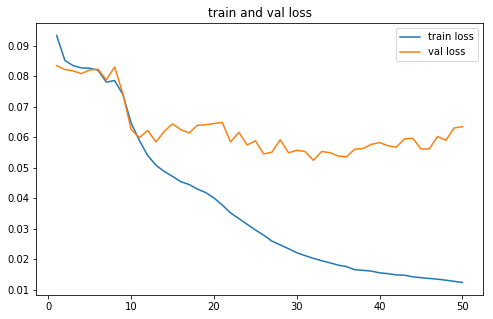

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = len(train_losses)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_losses, label='train loss')
plt.plot(np.arange(1,epochs+1), val_losses, label='val loss')
plt.title('train and val loss')
plt.legend()

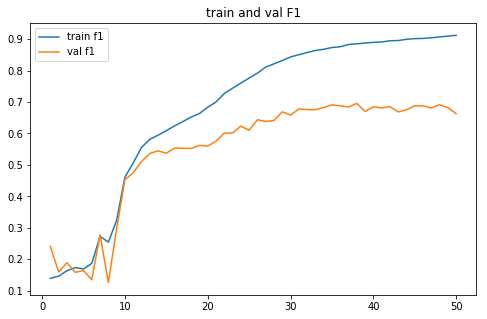

In [132]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_f1s, label='train f1')
plt.plot(np.arange(1,epochs+1), val_f1s, label='val f1')
plt.title('train and val F1')
plt.legend()

In [50]:
### Save it
#results = pd.DataFrame()


In [143]:
model_name = type(model).__name__
model_name

'LSTM'

In [140]:
# Give description
desc = "LSTM ver2 Adam lr=1e-2, betas=(0.9, 0.99)"
test_f1 = 0.677

In [141]:
desc 

'LSTM ver2 Adam lr=1e-2, betas=(0.9, 0.99)'

In [72]:
test_f1 = 0.845

In [ ]:
results = results.append({'Model': model_name,
                          'Desc' : desc,
                          'Test_f1': test_f1,
                          'Train_loss': pd.DataFrame({'Train_loss':train_losses}), 
                                         'Train_f1': pd.DataFrame({'Train_f1':train_f1s}), 
                                         'Val_loss': pd.DataFrame({'Val_loss':val_losses}), 
                                         'Val_f1': pd.DataFrame({'Val_f1':val_f1s})  }, ignore_index=True)

results

In [159]:
#results.to_pickle('results_gather.pkl')
results.to_pickle('results.pkl')

In [ ]:
# optional
res = results

In [42]:
res = pd.read_pickle('results.pkl')

In [46]:
res

,Desc,Model,Test_f1,Train_f1,Train_loss,Val_f1,Val_loss
0,"CNN 200x3,5,7 channel 0.5 drop",CNN2,0.845,Train_f1 0 0.706219 1 0.799025 2 0.8...,Train_loss 0 0.040085 1 0.027789 2...,Val_f1 0 0.803238 1 0.819120 2 0.8...,Val_loss 0 0.032640 1 0.030740 2 0.0...
1,LSTM fc2 hid_dim 200,LSTM,0.817,Train_f1 0 0.024328 1 0.248891 2 0.6...,Train_loss 0 0.088849 1 0.074960 2...,Val_f1 0 1.000000 1 0.496992 2 0.6...,Val_loss 0 0.085784 1 0.062822 2 0.0...
2,LSTM fc2 hid_dim 200 2-layers,LSTM,0.839,Train_f1 0 0.026060 1 0.018679 2 0.1...,Train_loss 0 0.088339 1 0.085261 2...,Val_f1 0 1.000000 1 0.160398 2 0.2...,Val_loss 0 0.085547 1 0.083617 2 0.0...


In [59]:
res['Desc'][1]= 'LSTM fc2 hid_dim 200 1-layer'
res['Desc'][2]= 'LSTM fc2 hid_dim 200 2-layers'

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
len(res)

3

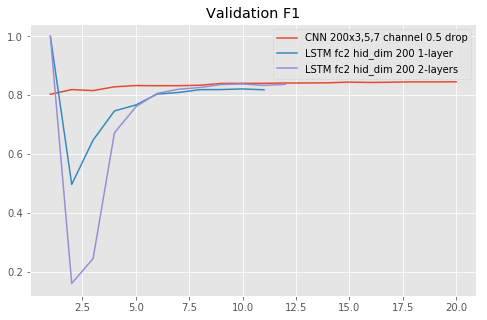

In [61]:
epochs = len(train_losses)

plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(np.arange(1,epochs+1), res['Val_f1'][i], label=res['Desc'][i] +'')

plt.title('Validation F1')
plt.legend()
plt.show()

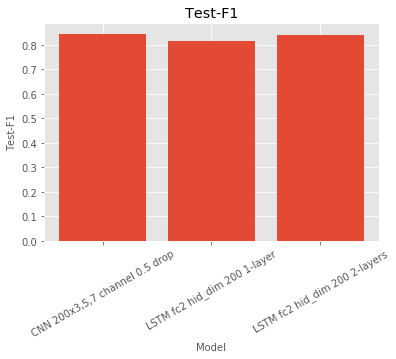

In [85]:
# Bar
index = np.arange(len(res))
values = res['Test_f1']
labels = res['Desc']

plt.ylim = ([0.5, 0.9]) # is set, but not effecting bar
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Test-F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=30)
plt.title('Test-F1')

plt.show()

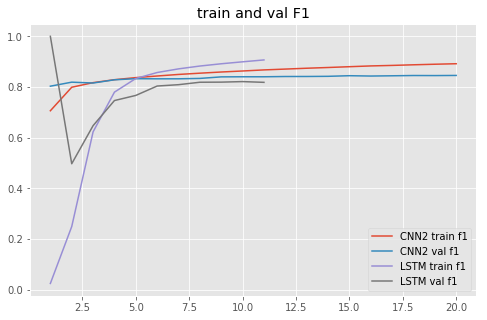

In [62]:
#epochs = len(train_losses)
plt.switch_backend('agg')
epochs = 40

plt.figure(figsize=(8,5))

epochs = len(res['Train_f1'][0])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][0], label=res['Model'][0] +' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][0], label=res['Model'][0] +' val f1')

epochs = len(res['Train_f1'][1])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][1], label=res['Model'][1]+ ' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][1], label=res['Model'][1] + ' val f1')


plt.title('train and val F1')
plt.legend()

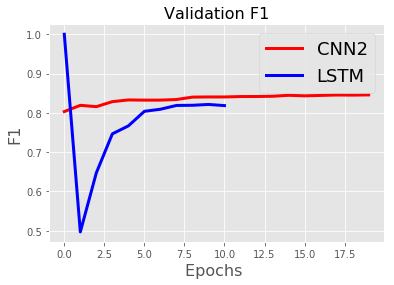

In [63]:
# grey background with lines
plt.style.use('ggplot')

fig1 = plt.figure()
plt.plot(res['Val_f1'][0],'r',linewidth=3.0)
plt.plot(res['Val_f1'][1],'b',linewidth=3.0)
plt.legend([res['Model'][0], res['Model'][1]],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1',fontsize=16)
plt.title('Validation F1',fontsize=16)
fig1.savefig('figure1.png')
plt.show()

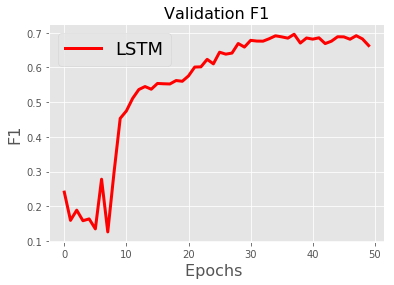

In [161]:
# grey background with lines
plt.style.use('ggplot')

fig1 = plt.figure()
plt.plot(res['Val_f1'][0],'r',linewidth=3.0)
#plt.plot(res['Val_f1'][1],'b',linewidth=3.0)
#plt.legend([res['Model'][0], res['Model'][1]],fontsize=18)
plt.legend([res['Model'][0]],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1',fontsize=16)
plt.title('Validation F1',fontsize=16)
fig1.savefig('figure.png')
plt.show()

### Save the model

For this version create the model object with same paramters as when training. Then load weights.
This version saves also gradients etc.

In [ ]:
torch.save(model.state_dict(), 'model.pkl')
#torch.save(model, 'filename.pt')

In [ ]:
model2 = RNN(input_dim=25002, embedding_dim=50, hidden_dim=256, output_dim=126)

In [ ]:
model2.load_state_dict(torch.load('model.pkl'))
                      

In [ ]:
model2.eval()

#### easier but not so compatible
This version does not save the gradients, only final model. 
Here you dont ened to create model object frist.

In [ ]:
#torch.save(model, 'models/model_cnn_200x3_4_5_drop05_emb5_f1_0845.pt')
torch.save(model, 'models/model_.pt')
# Works on CNN
# Some error on LSTM: TypeError: can't pickle torch.Device objects

In [ ]:
modelx = torch.load('modelx.pt')

### Test it on test data

In [136]:
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')

| Test Loss: 0.060 ||Prec:0.707 |Rec:0.650 |Test F1: 0.677 |


### Use final scoring 

The results will be ranked according to the highest micro-averaged F1 score. This will be calculated using the f1_score function found in scikit-learn, using a command like f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document i contains the label j.

In [ ]:
from sklearn.metrics import f1_score
f1_score()